In [37]:
import pycocotools.mask as mask_util
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import itertools as it
import csv
from skimage import data, img_as_float,io
from copy import deepcopy
from skimage.transform import rescale, resize
import warnings
warnings.filterwarnings("ignore")


In [38]:
def get_outline_contour(img,position):
    # Input: grey-scaled image of shell, position of shell in image e.g. left,right, or "longest" for longest contour. 
    # Output: contour of desired shell.
    # Note: if there's only one shell in the image, use position="longest".
    
    # Get all contours:
    thresh = threshold_otsu(img)
    binary = img > thresh
    cont = measure.find_contours(binary, 0.8)
    
    # Compute lengths of contours:
    cont_ln = []
    for n, contour in enumerate(cont):
        cont_ln.append(len(contour))
        
    if position == "longest":
        k = np.argmax(cont_ln)
        contour = cont[k]
    
    else:
        # Find longest contours:
        longest_c = sorted(cont_ln,reverse=True)[:2] # Assuming there are no more than 2 shell views in one image
        long_ind = []
        minx = []
        for i in range(0,len(cont_ln)):
            if cont_ln[i] in longest_c:
                long_ind.append(i)
                c = cont[i]
                x = c[:,1]
                minx.append(min(x))

        if "left" in position:
            contour = cont[long_ind[np.argmin(minx)]]
        else:
            # if we're looking for the right-most contour
            contour = cont[long_ind[np.argmax(minx)]]        
            
    return contour

def binarize_shell(img):
    # Input: coloured image
    # Output: edited image that has either black or white pixels.
    
    # 1) Get image size
    ###################
    x_len = len(img[0])
    y_len = len(img)
    img2 = deepcopy(img)

    # 2) Binarize image
    ###################
    # Pixels that are not white will be turned black, all other pixels will be turned white.
    for i in range(0,y_len):
        for j in range(0,x_len):
            if sum(img[i][j]) <= 755:
                img2[i][j] = [0,0,0]
            else:
                img2[i][j] = [255,255,255]


    return img2


In [57]:
gt = pd.read_csv('ite1/gt.csv')
predict = pd.read_csv('ite1/predictdf.csv')

In [58]:
len(gt)

482

In [59]:
predict['size'] = predict['size'].map(lambda x: x.lstrip('c(').rstrip(')'))
masksp = []

for row in predict.iterrows():
    segment = {}
    segment["counts"] = row[1][6]
    segment["size"] = [int(s) for s in row[1][5].split(',')]
    masksp.append(mask_util.decode(segment)[:, :])
predict['mask'] = masksp
# predict['predict_seg'] = coordsp

In [60]:
coordsp = []

for row in predict.iterrows():
    try:
        contour = get_outline_contour(row[1][7],"longest")
        x = contour[:,1]
        y = contour[:,0]
        contour = list(zip(x, y))
    except:
        contour = (0,0)
    coordsp.append(contour)
predict['predict_seg'] = coordsp

In [61]:
predict.head(1)

,Unnamed: 0,image_id,category_id,bbox,score,size,counts,mask,predict_seg
0,1,AM01,2,"c(327.602905273438, 214.81462097168, 90.728515...",0.99906,"600, 800",]QX69]b03N3M2a^OG\`0:c_OH[`0:b_OI\`09`_OJ_`08^...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(351.0, 293.2), (350.0, 293.2), (349.0, 293.2..."


In [62]:
gt['seg'] = gt['seg'].map(lambda x: x.lstrip('list(c(').rstrip(')'))

In [63]:
masksg = []
for row in gt.iterrows():
    polygon = [float(s) for s in row[1]["seg"].split(',')]
    img = Image.new('L', (row[1]["width"], row[1]["height"]), 0)
#     polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    masksg.append(mask)
gt['mask'] = masksg

In [64]:
goodseg = []
for row in gt.iterrows():
    gseg = row[1]["seg"].replace("\n", "").split(',')
    seg = [float(item) for item in gseg]
    x = seg[::2]
    y = seg[1::2]
    gseg = list(zip(x, y))
    goodseg.append(gseg)
gt['goodseg'] = goodseg

In [65]:
gt['size'] = gt['height'].apply(str) +","+gt['width'].apply(str)

In [66]:
gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]

,Unnamed: 0,image_id,seg,is_crowd,category_id,id,bbox,area,license,file_name,width,height,mask,goodseg,size


In [67]:
gt["mask"][0].shape

(600, 800)

In [68]:
predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]

,Unnamed: 0,image_id,category_id,bbox,score,size,counts,mask,predict_seg


In [69]:
predict["mask"][0].shape

(600, 800)

In [70]:
iougtlist = []
count = 0
for row in predict.iterrows():
    pmask = np.array(row[1]["mask"], dtype=bool)
    subgt = gt.loc[(gt['image_id'] == row[1]["image_id"])&(gt['category_id'] == row[1]["category_id"])]
    if len(subgt)>0:
#         print("len:")
#         print(len(subgt))
        templist = []
        for r in subgt.iterrows():
            gmask = np.array(r[1]["mask"], dtype=bool)
            moverlap = pmask*gmask
            munion = pmask+gmask
            mIOU = moverlap.sum()/float(munion.sum())
            mseg = r[1]["goodseg"]
            templist.append([mIOU,r[1]["id"],len(subgt), mseg])
        iougtlist.append(max(templist))
    else:
#         print("----len:")
#         print(len(subgt))
        iougtlist.append([0,0,0,0])
    count = count+1
    if count%500==0:
        print(str(count)+"/6000")
#     if row[1]["image_id"] != "AM05":
#         print("count")
#         print(count)
#         print(len(iougtlist))
#         break

500/6000
1000/6000
1500/6000
2000/6000
2500/6000
3000/6000
3500/6000
4000/6000
4500/6000
5000/6000
5500/6000
6000/6000


In [71]:
ioulist, gtlist, gtcount, gt_seg = map(list, zip(*iougtlist)) 

In [72]:
predict['iou'] = ioulist
predict['gt'] = gtlist
predict['gtcount'] = gtcount
predict['gt_seg'] = gt_seg

In [73]:
predict.head(10)

,Unnamed: 0,image_id,category_id,bbox,score,size,counts,mask,predict_seg,iou,gt,gtcount,gt_seg
0,1,AM01,2,"c(327.602905273438, 214.81462097168, 90.728515...",0.999060,"600, 800",]QX69]b03N3M2a^OG\`0:c_OH[`0:b_OI\`09`_OJ_`08^...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(351.0, 293.2), (350.0, 293.2), (349.0, 293.2...",0.888031,1,6,"[(351.8, 292.0), (352.0, 291.8), (353.0, 291.8..."
1,2,AM01,2,"c(299.171142578125, 302.658966064453, 90.22628...",0.999009,"600, 800",bTg5=Xb04N3M2M3N2O0P_O\Ok?f0R@\Om?e0R@\Om?d0R@...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(321.0, 392.2), (320.0, 392.2), (319.0, 392.2...",0.898310,6,6,"[(325.8, 390.0), (326.0, 389.8), (327.0, 389.8..."
2,3,AM01,2,"c(185.815979003906, 248.465698242188, 100.3563...",0.998865,"600, 800",\Wg3:Tb0=J4N2L9H5L2N2K6K4N2O1N2O1O000000000000...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(237.0, 324.2), (236.0, 324.2), (235.0, 324.2...",0.855088,5,6,"[(236.8, 326.0), (237.0, 325.8), (237.8, 325.0..."
3,4,AM01,2,"c(299.936767578125, 120.28108215332, 91.130065...",0.998543,"600, 800",mbg5:Xa0Jg_O;T`0Kh_O6U`01e_O1Z`01d_O0[`01d_O0[...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(318.0, 208.2), (317.0, 208.2), (316.0, 208.2...",0.887185,4,6,"[(318.8, 210.0), (319.0, 209.8), (319.8, 209.0..."
4,5,AM01,2,"c(225.754974365234, 169.364074707031, 95.86196...",0.998312,"600, 800",U]]4=Xb09H7I3N2N3M101M2O2N2N1O2N101N2O0O2O001N...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(265.0, 241.2), (264.0, 241.2), (263.0, 241.2...",0.827696,3,6,"[(268.8, 240.0), (269.0, 239.8), (270.0, 239.8..."
5,6,AM01,1,"c(335.793518066406, 478.850341796875, 79.80645...",0.095649,"600, 800",`i[61fb05L1O2N1O001OIe]O1[b00d]O1[b0Of]O1Yb0Og...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(397.0, 509.2), (396.0, 509.2), (395.0, 509.2...",0.000000,0,0,0
6,7,AM01,3,"c(224.56965637207, 171.669479370117, 97.088119...",0.006887,"600, 800",lo]44bb09H<C5L3N1N2N1O1N3N100O2N2M3N2O1O001N2O...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(265.0, 240.2), (264.0, 240.2), (263.0, 240.2...",0.000000,0,0,0
7,8,AM01,1,"c(224.678573608398, 169.726150512695, 98.78157...",0.006461,"600, 800",`fb44db002MoY21PfM1001N10`^O0X`00h_O1lN0Va0On_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(275.0, 196.2), (274.8, 196.0), (274.8, 195.0...",0.000000,0,0,0
8,9,AM01,3,"c(296.443939208984, 302.831817626953, 94.95553...",0.004596,"600, 800",oYh5b0Ub01O2o^O]Oj?d0T@@i?b0U@@i?`0V@Ak??S@Cl?...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(318.0, 393.2), (317.8, 393.0), (317.0, 392.2...",0.000000,0,0,0
9,10,AM01,3,"c(187.845779418945, 247.705169677734, 95.04072...",0.004526,"600, 800",Wjg36Rb0LX^O;da0>N1O1N201M=^OgNm^O]1Pa08N1O1O1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(237.0, 323.2), (236.0, 323.2), (235.0, 323.2...",0.000000,0,0,0


In [74]:
PRcal = predict[['image_id', 'category_id','score','iou','gt','gtcount',"predict_seg","gt_seg"]]
PRcal.to_csv("ite1/PRcal_withsegs.csv")

In [27]:
PRcal

,image_id,category_id,score,iou,gt,gtcount
0,AM01,2,9.990602e-01,0.888031,1,6
1,AM01,2,9.990093e-01,0.898310,6,6
2,AM01,2,9.988652e-01,0.855088,5,6
3,AM01,2,9.985429e-01,0.887185,4,6
4,AM01,2,9.983121e-01,0.827696,3,6
...,...,...,...,...,...,...
5995,VA62_0,1,1.224226e-07,0.000000,239,4
5996,VA62_0,1,1.222264e-07,0.000000,239,4
5997,VA62_0,1,1.167613e-07,0.000000,239,4
5998,VA62_0,1,1.166519e-07,0.012475,238,4


In [ ]:
# !!!!!these are playground code to make above work and test if they are correct!!!!!

In [ ]:
# gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')] is per image per motif gt
# predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')] is per image per motif prediction
# calculate iou on each prediction over each gt, in this case, 4 iou per prediction
# keep the highest, and over [50%](maybe 40?) iou for a gt per prediction, others being fp
# rank prediciton iou per gt, first being tp, others being fp

In [9]:
pmask0 = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][0], dtype=bool)
pmask1 = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][1], dtype=bool)
pmask2 = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][2], dtype=bool)
pmask3 = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][3], dtype=bool)
gmask0 = np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][0], dtype=bool)
gmask1 = np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][1], dtype=bool)
gmask2 = np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][2], dtype=bool)
gmask3 = np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][3], dtype=bool)
IOU = []
for i in range(4):
    moverlap = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][0], dtype=bool) * np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][i], dtype=bool)
    munion = np.array(predict.loc[(predict['category_id'] == 3) & (predict['image_id'] == 'AM05')]["mask"][0], dtype=bool) +np.array(gt.loc[(gt['category_id'] == 3) & (gt['image_id'] == 'AM05')]["mask"][i], dtype=bool)
    mIOU = moverlap.sum()/float(munion.sum())
    IOU.append(mIOU)
IOU


[0.0, 0.0, 0.0, 0.9295415959252971]

predict


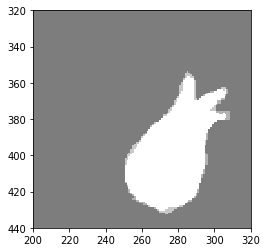

In [26]:
plt.imshow(gmask1, alpha=.3,cmap='gray')
plt.imshow(pmask1, alpha=.3,cmap='gray')
plt.xlim(200,320)
plt.ylim(440,320)
print("predict")

predict


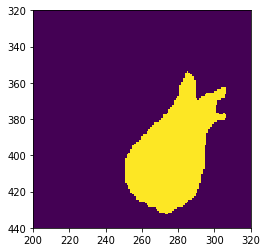

In [16]:
plt.imshow(pmask1, alpha=1)
plt.xlim(200,320)
plt.ylim(440,320)
print("predict")

In [13]:
print("ground truth:")
print(sum(gmask1))
print("predict:")
print(sum(pmask0))

ground truth:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  9 15 20 22 25 28 30 32 34 36 38 40 41
 42 45 46 47 48 48 50 51 52 51 52 52 53 55 56 58 60 61 63 69 69 70 69 68
 66 54 53 51 47 45 44 32 31 20 19 16 14 13 13 13 11 10  9  8  5  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
print("overlap:")
print(sum(overlap))
print("union:")
print(sum(union))

In [ ]:
import numpy as np
c1 = np.array([[0,0,0,1,1,0],[0,0,0,1,1,0],[0,0,0,1,1,0]], dtype=bool)
c2 = np.array([[0,0,1,1,0,0],[0,0,1,1,0,0],[0,0,1,1,0,0]], dtype=bool)

o = component1*component2 # Logical AND
u = component1 + component2 # Logical OR

iouscore = o.sum()/float(u.sum()) # Treats "True" as 1,
                                       # sums number of Trues
                                       # in overlap and union
                                       # and divides
print(1*c1)
print(1*c2)
print("---------------")
print(1*o)
print(1*u)
print(iouscore)